In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [124]:
nfl_teams=["ARI", "ATL", "BAL", "BUF", "CAR", "CHI", "CIN", "CLE", "DAL", "DEN", 
           "DET", "GB", "HOU", "IND", "JAX", "KC", "LV", "LAC", "LA", "MIA", 
           "MIN", "NE", "NO", "NYG", "NYJ", "PHI", "PIT", "SF", "SEA", "TB", 
           "TEN", "WAS"]

ep_sets = []
down = 1
distance = 10

unfinished = []

for team in nfl_teams:
    try:
        ep_set_df = pd.read_csv('team_data/team-data/'+team+'/norm_def_eps.csv')
        ep_set = ep_set_df[ep_set_df['Down'] == down]
        ep_set = ep_set[((ep_set['Distance'] == distance) & (ep_set['Yardline'] >= distance)) | ((ep_set['Yardline'] < distance) 
                                                                                                    & (ep_set['Distance'] == ep_set['Yardline']))]
        ep_sets.append((team, ep_set))
    except:
        unfinished.append(team)
        pass

nfl = pd.read_csv('team_data/nfl_eps/norm_eps.csv')
ep_set_nfl = nfl[nfl['Down'] == down]
ep_set_nfl = ep_set_nfl[((ep_set_nfl['Distance'] == distance) & (ep_set_nfl['Yardline'] >= distance)) | ((ep_set_nfl['Yardline'] < distance) 
                                                                                                   & (ep_set_nfl['Distance'] == ep_set_nfl['Yardline']))]
#ep_sets.append(("NFL", ep_set_nfl))

print(unfinished)

[]


In [125]:
# Sort ep_sets by the sum of EP in ascending order
sorted_ep_sets = sorted(ep_sets, key=lambda ep_set: np.sum(ep_set[1]['EP']), reverse=True)

snamelist=[]

# Print names in order
for name, _ in sorted_ep_sets:
    snamelist.append(name)

print(snamelist)

['JAX', 'CAR', 'ATL', 'NE', 'ARI', 'SEA', 'NYG', 'MIA', 'CLE', 'LV', 'NO', 'LA', 'KC', 'CIN', 'DAL', 'TEN', 'TB', 'NYJ', 'DET', 'BAL', 'PHI', 'PIT', 'HOU', 'CHI', 'GB', 'WAS', 'IND', 'SF', 'LAC', 'BUF', 'DEN', 'MIN']


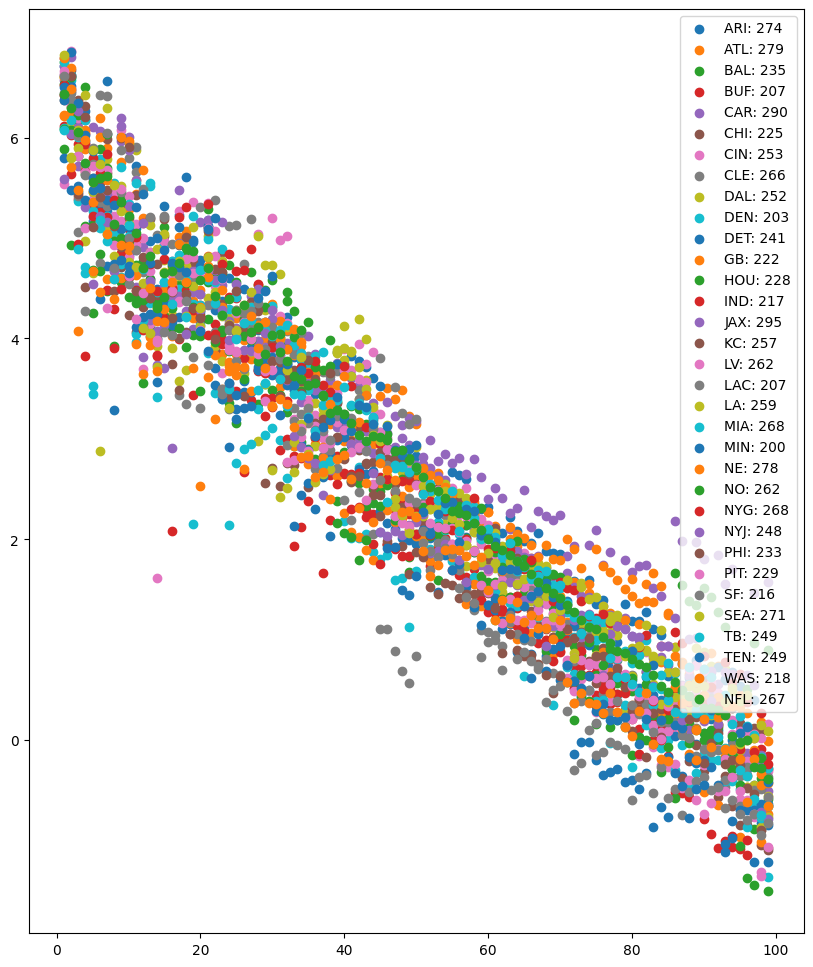

In [126]:
plt.figure(figsize=(10, 12))

for ep_set in ep_sets:
    name, set = ep_set
    plt.scatter(set['Yardline'], set['EP'], label = name+": "+str(int(np.sum(set['EP']))))

plt.scatter(ep_set_nfl['Yardline'], ep_set_nfl['EP'], label = "NFL: "+str(int(np.sum(ep_set_nfl['EP']))))
plt.legend()

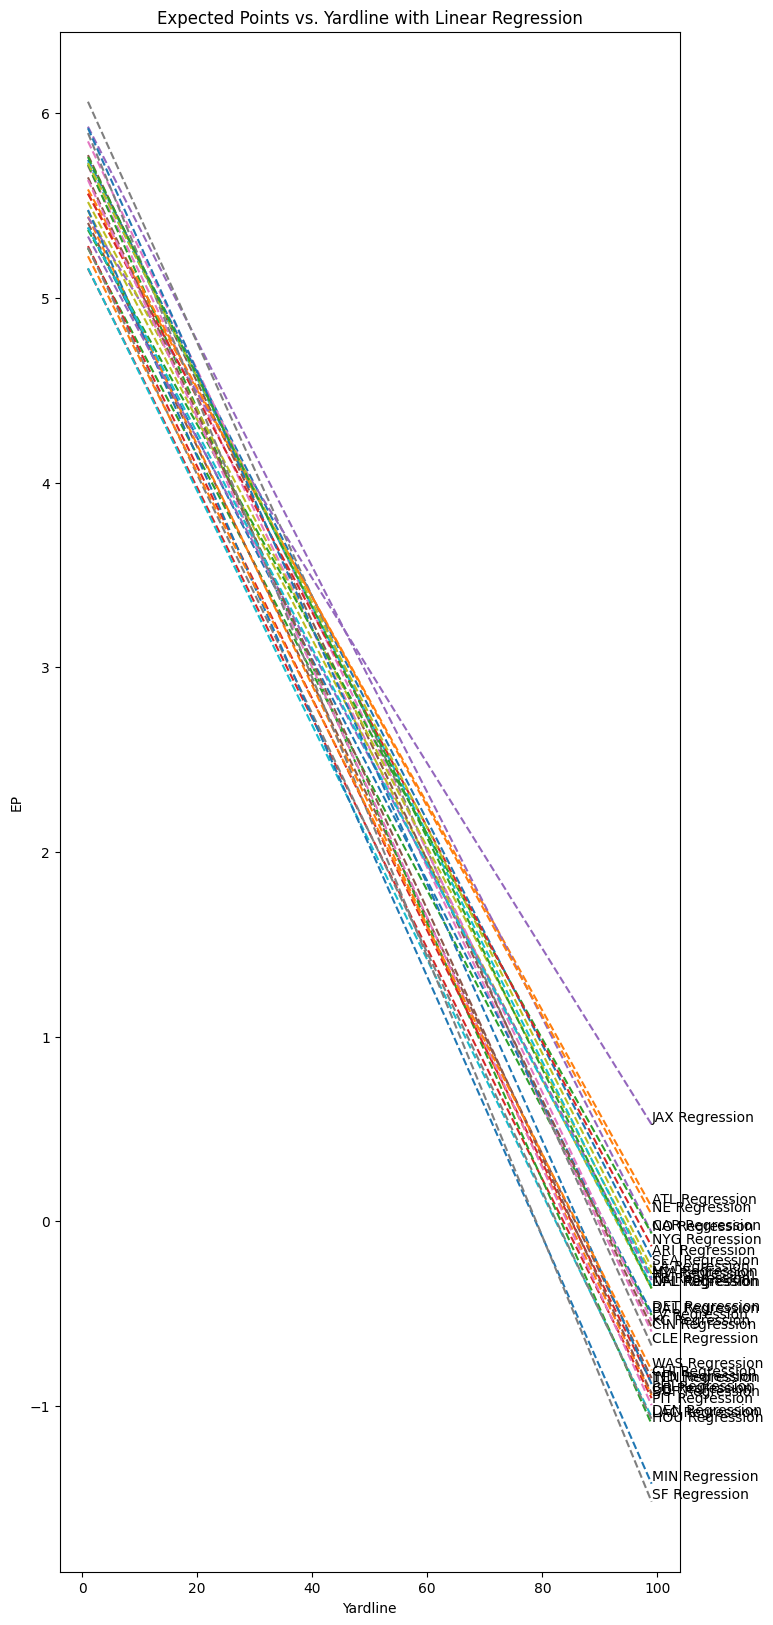

In [127]:

plt.figure(figsize=(8, 20))

# Plot scatter points and regression lines
for ep_set in ep_sets:
    name, set = ep_set
    
    # Compute linear regression line
    coeffs = np.polyfit(set['Yardline'], set['EP'], 1)
    x_vals = np.linspace(min(set['Yardline']), max(set['Yardline']), 100)
    y_vals = np.polyval(coeffs, x_vals)
    
    # Plot regression line
    plt.plot(x_vals, y_vals, linestyle="--", label=f"{name} Regression")

    # Label the line at its rightmost point
    plt.text(x_vals[-1], y_vals[-1], f"{name} Regression", verticalalignment='bottom', fontsize=10)

# Compute and plot NFL regression line
nfl_coeffs = np.polyfit(ep_set_nfl['Yardline'], ep_set_nfl['EP'], 1)
x_vals_nfl = np.linspace(min(ep_set_nfl['Yardline']), max(ep_set_nfl['Yardline']), 100)
y_vals_nfl = np.polyval(nfl_coeffs, x_vals_nfl)

# Plot NFL regression line
plt.plot(x_vals_nfl, y_vals_nfl, linestyle="--", label="NFL Regression")

# Label the NFL line at its rightmost point
plt.text(x_vals_nfl[-1], y_vals_nfl[-1], "NFL Regression", verticalalignment='bottom', fontsize=10)

plt.xlabel("Yardline")
plt.ylabel("EP")
plt.title("Expected Points vs. Yardline with Linear Regression")
plt.show()

In [128]:
# Create a list of (name, total_EP) tuples
ep_sums = [(name, np.sum(df['EP'])) for name, df in ep_sets]

# Sort by total_EP
ep_sums_sorted = sorted(ep_sums, key=lambda x: x[1], reverse=False)  # reverse=False for ascending

# Print results
for name, total in ep_sums_sorted:
    print(f"{name}: {total:.2f}")


MIN: 200.74
DEN: 203.02
BUF: 207.95
LAC: 207.98
SF: 216.52
IND: 217.96
WAS: 218.73
GB: 222.75
CHI: 225.57
HOU: 228.87
PIT: 229.81
PHI: 233.69
BAL: 235.67
DET: 241.83
NYJ: 248.21
TB: 249.15
TEN: 249.37
DAL: 252.88
CIN: 253.30
KC: 257.46
LA: 259.17
NO: 262.46
LV: 262.76
CLE: 266.79
MIA: 268.65
NYG: 268.74
SEA: 271.25
ARI: 274.80
NE: 278.41
ATL: 279.30
CAR: 290.41
JAX: 295.09


In [129]:
freq_df = pd.read_csv("frequency.csv")

In [130]:
# Rename for consistency
freq_df.rename(columns={'down': 'Down', 'distance': 'Distance', 'yardline': 'Yardline'}, inplace=True)

# Apply the same filtering logic to match df in ep_sets:
# - down == 1
# - (distance == 10 and yardline >= 10) OR (distance == yardline and yardline < 10)
freq_df_filtered = freq_df[
    (freq_df['Down'] == 1) &
    (
        ((freq_df['Distance'] == 10) & (freq_df['Yardline'] >= 10)) |
        ((freq_df['Distance'] == freq_df['Yardline']) & (freq_df['Yardline'] < 10))
    )
]

tot = np.sum(freq_df_filtered['frequency'])

# Now compute weighted sums
ep_sums = []
for name, df in ep_sets:
    # Merge EP and frequency data on Down, Distance, Yardline
    merged = pd.merge(df, freq_df_filtered, on=['Down', 'Distance', 'Yardline'], how='inner')

    # Compute weighted EP
    merged['weighted_ep'] = merged['EP'] * merged['frequency']
    total_weighted_ep = merged['weighted_ep'].sum()

    ep_sums.append((name, total_weighted_ep/tot))

# Sort and print
ep_sums_sorted = sorted(ep_sums, key=lambda x: x[1], reverse=False)
rank = 1
for name, total in ep_sums_sorted:
    print(f"{rank:2d}: {name:<3}: {total:.2f}")
    rank+=1

 1: MIN: 1.76
 2: LAC: 1.83
 3: DEN: 1.86
 4: SF : 1.90
 5: BUF: 1.95
 6: IND: 1.98
 7: WAS: 1.98
 8: GB : 2.07
 9: HOU: 2.09
10: CHI: 2.09
11: PHI: 2.16
12: PIT: 2.16
13: DET: 2.20
14: BAL: 2.25
15: NYJ: 2.31
16: TEN: 2.32
17: CIN: 2.34
18: KC : 2.36
19: NO : 2.39
20: DAL: 2.39
21: TB : 2.42
22: LV : 2.42
23: LA : 2.46
24: CLE: 2.49
25: MIA: 2.52
26: NYG: 2.53
27: SEA: 2.57
28: ATL: 2.65
29: ARI: 2.69
30: NE : 2.74
31: CAR: 2.80
32: JAX: 2.83
